# Facial Emotion Recognition

**Final Training Notebook**  
After extensive experimentations with different models on our dataset and hyperparamerter tunning, in this notebook, the final two models will be trained for the real-time application. 
* The dataset used here is a [FER-2013](https://www.kaggle.com/datasets/msambare/fer2013), which is a challenging due to its imbalance and small image size (48x38 pixels). 
* Both the models are trained for 30 epochs and the hyperparameters are selected after experiments with different hyperparameters for the model.
* Final model for the application will be selected after their accuracy and inference rate comparison.
* For training, NVIDA GeForce GTX 1070 Ti is used.

In [1]:
import os
import time
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import clip

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import datasets, transforms, models
from transformers import CLIPModel, CLIPProcessor
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

**Device agnostic Code**

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
print(torch.cuda.get_device_name(0))

NVIDIA GeForce GTX 1070 Ti


In [4]:
!nvidia-smi

Wed Oct 23 08:34:33 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 561.09                 Driver Version: 561.09         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1070 Ti   WDDM  |   00000000:01:00.0 Off |                  N/A |
|  0%   37C    P8             10W /  180W |       0MiB /   8192MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Dataset Overview

* [FER-2013](https://www.kaggle.com/datasets/msambare/fer2013) dataset is used..
* The dataset consists of 48x48 pixel grayscale images of faces, categorized into seven emotions. 
* The data is organized into training and testing sets with subfolders representing each emotion.

```bash
data
 |- train
    |- angry
    |- disgust
    |- fear
    |- happy
    |- neutral
    |- sad
    |- surprise
 |- test
    |- angry
    |- disgust
    |- fear
    |- happy
    |- neutral
    |- sad
    |- surprise
```

## Data Loading and Visualization

### Loading the Dataset
We'll use `ImageFolder` from `torchvision.datasets` to load the data. Since the images are grayscale, we'll convert them to RGB by duplicating the single channel to match the pretrained models' expected input.

In [5]:
data_dir = './data'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

**Define transformations**

In [6]:
# Pretrained models expect images of size at least 224x224 and 3 channels
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],  # Using ImageNet means
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

In [7]:
full_train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])

**Split the train set into train and validation sets**  

Since we have no predefined validation set in our dataset. So we'll split train dataset into separate train and validation subsets. This allows us to monitor the model's performance during training.

1. **Split the Training Dataset**  
    * We'll split the original training dataset into a new training set and a validation set.  
    **Split Ratios**  
        - **Training Set Ratio**: ~69.9%  
        - **Validation Set Ratio**: ~10.0%  
        - **Test Set Ratio**: ~20.0%  
    * Dataset is split into approximately 70% training, 10% validation, and 20% test.

In [8]:
# Define the size for training and validation sets
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

In [9]:
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

In [10]:
val_dataset.dataset.transform = data_transforms['val']

In [11]:
# Load the test dataset
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms['test'])

**Create DataLoader**

In [12]:
batch_size = 64
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4),
    'test': DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
}

In [13]:
dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'val', 'test']}
class_names = full_train_dataset.classes
print(f"Classes: {class_names}")
print(f"Training samples: {dataset_sizes['train']}")
print(f"Validation samples: {dataset_sizes['val']}")
print(f"Testing samples: {dataset_sizes['test']}")

Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Training samples: 22967
Validation samples: 5742
Testing samples: 7178


## Visualizing the Dataset


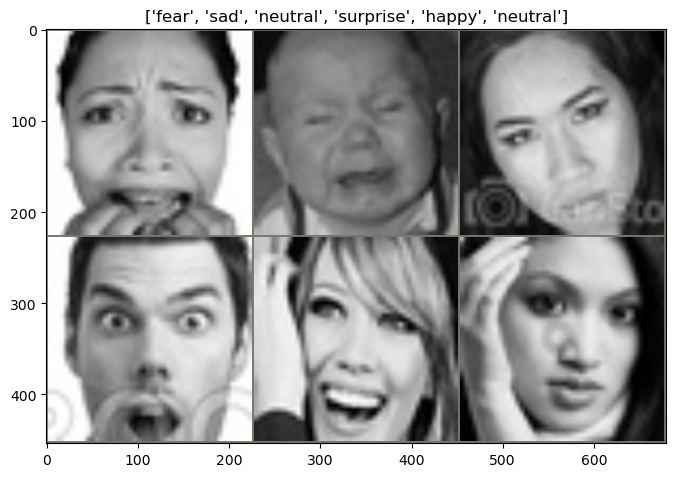

In [14]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))  # Convert to HWC format
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean  # Unnormalize
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause a bit so that plots are updated

# Get a small batch of 6 training images
inputs, classes = next(iter(DataLoader(train_dataset, batch_size=6, shuffle=True)))
out = torchvision.utils.make_grid(inputs, nrow=3)

# Visualize images with corresponding labels
plt.figure(figsize=(8, 8))
imshow(out, title=[class_names[x] for x in classes])
plt.show()

## Utility Functions
Define utility functions for training, evaluating, plotting, and tracking training time.

In [15]:
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time."""
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [16]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=15):
    since = time.time()

    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(1, num_epochs + 1):
        print(f'Epoch {epoch}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in tqdm(dataloaders[phase], desc=f'{phase}'):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track gradients only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only in train
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Validation Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history, time_elapsed

In [17]:
def evaluate_model(model, dataloader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Evaluating'):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f'Test Accuracy: {acc:.4f}')

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

    return acc

## Model Training and Evaluation

1. **Pretrained CNN-based Model**: `resnet18`
2. **CLIP Model** `clip-vit-base-patch32`

For each model, we'll:

* Initialize the model
* Modify the final layer to match our number of classes
* Define loss and optimizer
* Train the model
* Evaluate and save results

### Pretrained CNN Models

#### Resnet18

In [18]:
# Initialize ResNet18
model_resnet = models.resnet18(pretrained=True)

In [19]:
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, len(class_names))
model_resnet = model_resnet.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_resnet = torch.optim.Adam(model_resnet.parameters(), lr=1e-4, weight_decay=1e-4)

**Train the model**

In [20]:
model_resnet, history_resnet, train_time_resnet18 = train_model(
    model_resnet, dataloaders, criterion, optimizer_resnet, num_epochs=30
)

Epoch 1/30
----------


train: 100%|██████████| 359/359 [05:31<00:00,  1.08it/s]


Train Loss: 1.1737 Acc: 0.5554


val: 100%|██████████| 90/90 [01:29<00:00,  1.00it/s]


Val Loss: 0.9840 Acc: 0.6303

Epoch 2/30
----------


train: 100%|██████████| 359/359 [01:30<00:00,  3.98it/s]


Train Loss: 0.7857 Acc: 0.7149


val: 100%|██████████| 90/90 [00:24<00:00,  3.70it/s]


Val Loss: 0.9884 Acc: 0.6393

Epoch 3/30
----------


train: 100%|██████████| 359/359 [01:27<00:00,  4.10it/s]


Train Loss: 0.4433 Acc: 0.8493


val: 100%|██████████| 90/90 [00:24<00:00,  3.68it/s]


Val Loss: 1.0833 Acc: 0.6421

Epoch 4/30
----------


train: 100%|██████████| 359/359 [01:28<00:00,  4.08it/s]


Train Loss: 0.1686 Acc: 0.9526


val: 100%|██████████| 90/90 [00:24<00:00,  3.69it/s]


Val Loss: 1.2606 Acc: 0.6435

Epoch 5/30
----------


train: 100%|██████████| 359/359 [01:35<00:00,  3.74it/s]


Train Loss: 0.0726 Acc: 0.9840


val: 100%|██████████| 90/90 [00:37<00:00,  2.41it/s]


Val Loss: 1.3252 Acc: 0.6459

Epoch 6/30
----------


train: 100%|██████████| 359/359 [01:45<00:00,  3.40it/s]


Train Loss: 0.0494 Acc: 0.9900


val: 100%|██████████| 90/90 [00:27<00:00,  3.22it/s]


Val Loss: 1.4901 Acc: 0.6350

Epoch 7/30
----------


train: 100%|██████████| 359/359 [01:35<00:00,  3.77it/s]


Train Loss: 0.0406 Acc: 0.9916


val: 100%|██████████| 90/90 [00:28<00:00,  3.18it/s]


Val Loss: 1.5345 Acc: 0.6414

Epoch 8/30
----------


train: 100%|██████████| 359/359 [01:34<00:00,  3.82it/s]


Train Loss: 0.0836 Acc: 0.9746


val: 100%|██████████| 90/90 [00:27<00:00,  3.25it/s]


Val Loss: 1.7620 Acc: 0.6144

Epoch 9/30
----------


train: 100%|██████████| 359/359 [01:34<00:00,  3.82it/s]


Train Loss: 0.1271 Acc: 0.9551


val: 100%|██████████| 90/90 [00:28<00:00,  3.18it/s]


Val Loss: 1.6469 Acc: 0.6369

Epoch 10/30
----------


train: 100%|██████████| 359/359 [01:36<00:00,  3.71it/s]


Train Loss: 0.0659 Acc: 0.9791


val: 100%|██████████| 90/90 [00:31<00:00,  2.88it/s]


Val Loss: 1.6326 Acc: 0.6449

Epoch 11/30
----------


train: 100%|██████████| 359/359 [01:33<00:00,  3.82it/s]


Train Loss: 0.0309 Acc: 0.9920


val: 100%|██████████| 90/90 [00:27<00:00,  3.27it/s]


Val Loss: 1.6025 Acc: 0.6538

Epoch 12/30
----------


train: 100%|██████████| 359/359 [01:33<00:00,  3.83it/s]


Train Loss: 0.0159 Acc: 0.9957


val: 100%|██████████| 90/90 [00:26<00:00,  3.37it/s]


Val Loss: 1.5711 Acc: 0.6656

Epoch 13/30
----------


train: 100%|██████████| 359/359 [01:32<00:00,  3.86it/s]


Train Loss: 0.0105 Acc: 0.9973


val: 100%|██████████| 90/90 [00:26<00:00,  3.34it/s]


Val Loss: 1.5966 Acc: 0.6672

Epoch 14/30
----------


train: 100%|██████████| 359/359 [01:33<00:00,  3.82it/s]


Train Loss: 0.0109 Acc: 0.9968


val: 100%|██████████| 90/90 [00:26<00:00,  3.36it/s]


Val Loss: 1.6775 Acc: 0.6595

Epoch 15/30
----------


train: 100%|██████████| 359/359 [01:32<00:00,  3.87it/s]


Train Loss: 0.0883 Acc: 0.9703


val: 100%|██████████| 90/90 [00:26<00:00,  3.38it/s]


Val Loss: 1.8289 Acc: 0.6028

Epoch 16/30
----------


train: 100%|██████████| 359/359 [01:32<00:00,  3.86it/s]


Train Loss: 0.1681 Acc: 0.9403


val: 100%|██████████| 90/90 [00:26<00:00,  3.38it/s]


Val Loss: 1.6380 Acc: 0.6452

Epoch 17/30
----------


train: 100%|██████████| 359/359 [01:32<00:00,  3.87it/s]


Train Loss: 0.0383 Acc: 0.9884


val: 100%|██████████| 90/90 [00:26<00:00,  3.39it/s]


Val Loss: 1.6161 Acc: 0.6571

Epoch 18/30
----------


train: 100%|██████████| 359/359 [01:32<00:00,  3.87it/s]


Train Loss: 0.0162 Acc: 0.9954


val: 100%|██████████| 90/90 [00:27<00:00,  3.27it/s]


Val Loss: 1.6059 Acc: 0.6620

Epoch 19/30
----------


train: 100%|██████████| 359/359 [01:33<00:00,  3.84it/s]


Train Loss: 0.0093 Acc: 0.9972


val: 100%|██████████| 90/90 [00:26<00:00,  3.35it/s]


Val Loss: 1.5999 Acc: 0.6698

Epoch 20/30
----------


train: 100%|██████████| 359/359 [01:33<00:00,  3.85it/s]


Train Loss: 0.0070 Acc: 0.9977


val: 100%|██████████| 90/90 [00:27<00:00,  3.32it/s]


Val Loss: 1.6009 Acc: 0.6733

Epoch 21/30
----------


train: 100%|██████████| 359/359 [01:33<00:00,  3.86it/s]


Train Loss: 0.0056 Acc: 0.9974


val: 100%|██████████| 90/90 [00:27<00:00,  3.32it/s]


Val Loss: 1.6156 Acc: 0.6733

Epoch 22/30
----------


train: 100%|██████████| 359/359 [01:33<00:00,  3.86it/s]


Train Loss: 0.0048 Acc: 0.9978


val: 100%|██████████| 90/90 [00:26<00:00,  3.37it/s]


Val Loss: 1.5763 Acc: 0.6768

Epoch 23/30
----------


train: 100%|██████████| 359/359 [01:33<00:00,  3.84it/s]


Train Loss: 0.0053 Acc: 0.9976


val: 100%|██████████| 90/90 [00:26<00:00,  3.36it/s]


Val Loss: 1.5711 Acc: 0.6764

Epoch 24/30
----------


train: 100%|██████████| 359/359 [01:33<00:00,  3.86it/s]


Train Loss: 0.0049 Acc: 0.9977


val: 100%|██████████| 90/90 [00:26<00:00,  3.37it/s]


Val Loss: 1.5706 Acc: 0.6752

Epoch 25/30
----------


train: 100%|██████████| 359/359 [01:33<00:00,  3.84it/s]


Train Loss: 0.0047 Acc: 0.9977


val: 100%|██████████| 90/90 [00:26<00:00,  3.35it/s]


Val Loss: 1.5828 Acc: 0.6736

Epoch 26/30
----------


train: 100%|██████████| 359/359 [01:32<00:00,  3.86it/s]


Train Loss: 0.0830 Acc: 0.9724


val: 100%|██████████| 90/90 [00:26<00:00,  3.36it/s]


Val Loss: 2.0217 Acc: 0.4923

Epoch 27/30
----------


train: 100%|██████████| 359/359 [01:33<00:00,  3.85it/s]


Train Loss: 0.2649 Acc: 0.9064


val: 100%|██████████| 90/90 [00:26<00:00,  3.33it/s]


Val Loss: 1.7163 Acc: 0.6165

Epoch 28/30
----------


train: 100%|██████████| 359/359 [01:33<00:00,  3.86it/s]


Train Loss: 0.0405 Acc: 0.9879


val: 100%|██████████| 90/90 [00:26<00:00,  3.35it/s]


Val Loss: 1.6570 Acc: 0.6548

Epoch 29/30
----------


train: 100%|██████████| 359/359 [01:33<00:00,  3.85it/s]


Train Loss: 0.0138 Acc: 0.9966


val: 100%|██████████| 90/90 [00:26<00:00,  3.35it/s]


Val Loss: 1.5718 Acc: 0.6590

Epoch 30/30
----------


train: 100%|██████████| 359/359 [01:34<00:00,  3.78it/s]


Train Loss: 0.0069 Acc: 0.9979


val: 100%|██████████| 90/90 [00:27<00:00,  3.26it/s]

Val Loss: 1.5979 Acc: 0.6689

Training complete in 65m 29s
Best Validation Acc: 0.6768


**Evaluate the model**

Evaluating: 100%|██████████| 113/113 [01:07<00:00,  1.67it/s]


Test Accuracy: 0.6722


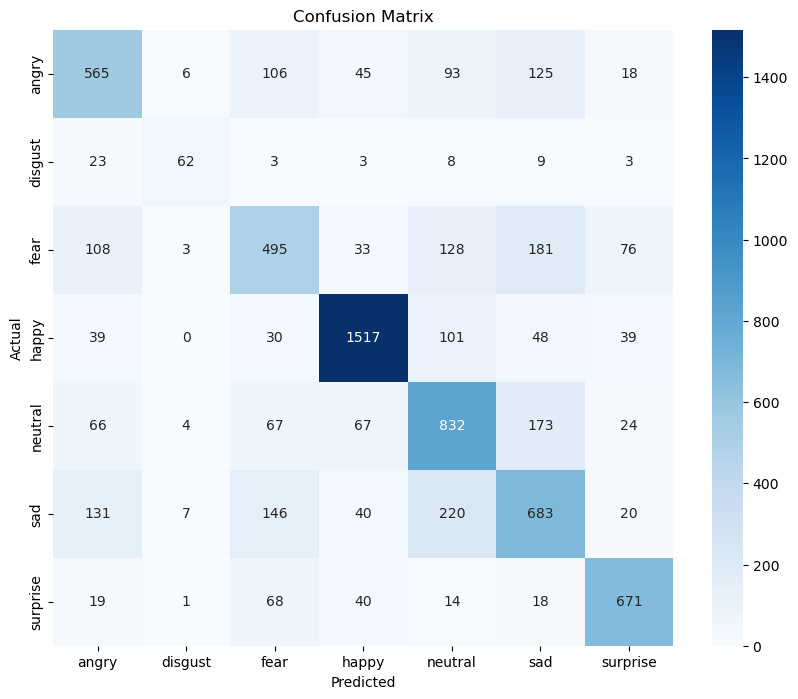

In [21]:
test_acc_resnet18 = evaluate_model(model_resnet, dataloaders['test'], class_names)

**Save the model**

In [22]:
torch.save(model_resnet.state_dict(), './models/resnet18_fer.pth')

**Plot learning curves**

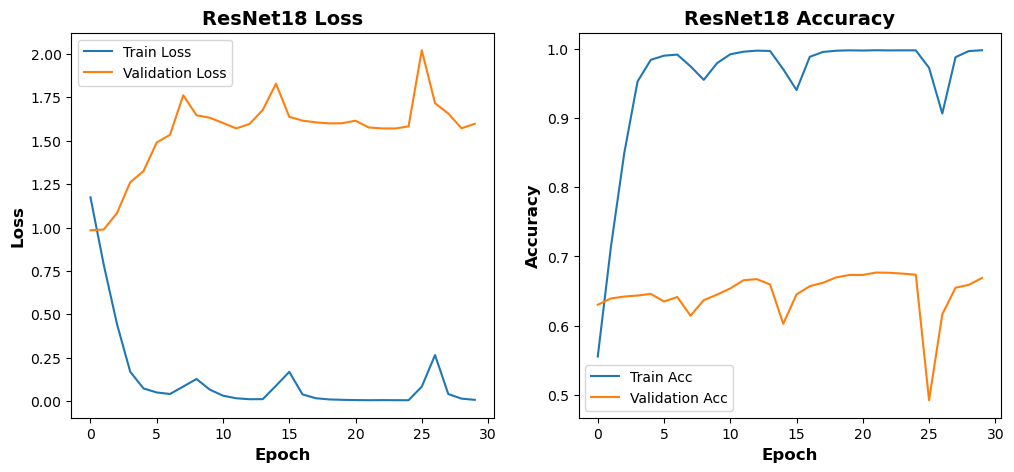

In [23]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_resnet['train_loss'], label='Train Loss')
plt.plot(history_resnet['val_loss'], label='Validation Loss')
plt.title('ResNet18 Loss', fontweight='bold', fontsize=14)
plt.xlabel('Epoch', fontweight='bold', fontsize=12)
plt.ylabel('Loss', fontweight='bold', fontsize=12)
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_resnet['train_acc'], label='Train Acc')
plt.plot(history_resnet['val_acc'], label='Validation Acc')
plt.title('ResNet18 Accuracy', fontweight='bold', fontsize=14)
plt.xlabel('Epoch', fontweight='bold', fontsize=12)
plt.ylabel('Accuracy', fontweight='bold', fontsize=12)
plt.legend()

plt.show()

----

## CLIP Model
* The CLIP model utilizes a `ViT-B/32` Transformer architecture as an image encoder, alongside a masked self-attention Transformer as a text encoder. These encoders are trained to maximize the similarity between (image, text) pairs through a contrastive loss function.

* Here we will adapt CLIP primarily as an **image encoder**, though it is originally designed for image-text tasks. This adaptation allows us to leverage its powerful feature extraction capabilities for classification tasks.

**Load CLIP Model and Processor**
* Load the CLIP model and its corresponding processor using Hugging Face library.

In [18]:
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

**CLIP Classifier Definition**
* Define a custom classifier that integrates the CLIP model for our classification tasks.
* The architecture includes a linear layer that maps the image features to the desired number of output classes.

In [19]:
class CLIPClassifier(nn.Module):
    def __init__(self, clip_model, num_classes):
        super(CLIPClassifier, self).__init__()
        self.clip_model = clip_model
        # input size of the linear layer based on expected output dimensions
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        with torch.no_grad():
            image_features = self.clip_model.get_image_features(pixel_values=x)
            image_features /= image_features.norm(dim=-1, keepdim=True)
        
        out = self.fc(image_features)
        return out

In [20]:
# Instantiate the model
model_clip_classifier = CLIPClassifier(clip_model, len(class_names))
model_clip_classifier = model_clip_classifier.to(device)

In [21]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_clip = torch.optim.Adam(model_clip_classifier.parameters(), lr=1e-3, weight_decay=1e-4)

**Train the model**

In [23]:
model_clip_classifier1, history_clip, train_time_clip = train_model(
    model_clip_classifier, dataloaders, criterion, optimizer_clip, num_epochs=30
)

Epoch 1/30
----------


train: 100%|██████████| 359/359 [06:37<00:00,  1.11s/it]


Train Loss: 1.6757 Acc: 0.3636


val: 100%|██████████| 90/90 [01:44<00:00,  1.16s/it]


Val Loss: 1.5190 Acc: 0.5078

Epoch 2/30
----------


train: 100%|██████████| 359/359 [01:38<00:00,  3.64it/s]


Train Loss: 1.4314 Acc: 0.5367


val: 100%|██████████| 90/90 [00:39<00:00,  2.27it/s]


Val Loss: 1.3607 Acc: 0.5592

Epoch 3/30
----------


train: 100%|██████████| 359/359 [01:39<00:00,  3.61it/s]


Train Loss: 1.3093 Acc: 0.5703


val: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Val Loss: 1.2711 Acc: 0.5806

Epoch 4/30
----------


train: 100%|██████████| 359/359 [01:40<00:00,  3.56it/s]


Train Loss: 1.2342 Acc: 0.5868


val: 100%|██████████| 90/90 [00:38<00:00,  2.32it/s]


Val Loss: 1.2116 Acc: 0.5954

Epoch 5/30
----------


train: 100%|██████████| 359/359 [01:40<00:00,  3.58it/s]


Train Loss: 1.1828 Acc: 0.5954


val: 100%|██████████| 90/90 [00:38<00:00,  2.32it/s]


Val Loss: 1.1706 Acc: 0.6033

Epoch 6/30
----------


train: 100%|██████████| 359/359 [01:40<00:00,  3.58it/s]


Train Loss: 1.1460 Acc: 0.6039


val: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Val Loss: 1.1405 Acc: 0.6090

Epoch 7/30
----------


train: 100%|██████████| 359/359 [01:40<00:00,  3.58it/s]


Train Loss: 1.1182 Acc: 0.6113


val: 100%|██████████| 90/90 [00:38<00:00,  2.32it/s]


Val Loss: 1.1176 Acc: 0.6116

Epoch 8/30
----------


train: 100%|██████████| 359/359 [01:40<00:00,  3.56it/s]


Train Loss: 1.0966 Acc: 0.6172


val: 100%|██████████| 90/90 [00:38<00:00,  2.31it/s]


Val Loss: 1.1001 Acc: 0.6169

Epoch 9/30
----------


train: 100%|██████████| 359/359 [01:39<00:00,  3.60it/s]


Train Loss: 1.0796 Acc: 0.6201


val: 100%|██████████| 90/90 [00:38<00:00,  2.31it/s]


Val Loss: 1.0865 Acc: 0.6186

Epoch 10/30
----------


train: 100%|██████████| 359/359 [01:40<00:00,  3.56it/s]


Train Loss: 1.0659 Acc: 0.6239


val: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Val Loss: 1.0744 Acc: 0.6233

Epoch 11/30
----------


train: 100%|██████████| 359/359 [01:40<00:00,  3.59it/s]


Train Loss: 1.0547 Acc: 0.6269


val: 100%|██████████| 90/90 [00:38<00:00,  2.33it/s]


Val Loss: 1.0657 Acc: 0.6277

Epoch 12/30
----------


train: 100%|██████████| 359/359 [01:40<00:00,  3.57it/s]


Train Loss: 1.0452 Acc: 0.6298


val: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Val Loss: 1.0587 Acc: 0.6299

Epoch 13/30
----------


train: 100%|██████████| 359/359 [01:40<00:00,  3.57it/s]


Train Loss: 1.0378 Acc: 0.6313


val: 100%|██████████| 90/90 [00:38<00:00,  2.32it/s]


Val Loss: 1.0512 Acc: 0.6313

Epoch 14/30
----------


train: 100%|██████████| 359/359 [01:40<00:00,  3.59it/s]


Train Loss: 1.0314 Acc: 0.6336


val: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Val Loss: 1.0461 Acc: 0.6311

Epoch 15/30
----------


train: 100%|██████████| 359/359 [01:39<00:00,  3.59it/s]


Train Loss: 1.0260 Acc: 0.6355


val: 100%|██████████| 90/90 [00:38<00:00,  2.34it/s]


Val Loss: 1.0417 Acc: 0.6362

Epoch 16/30
----------


train: 100%|██████████| 359/359 [01:39<00:00,  3.60it/s]


Train Loss: 1.0212 Acc: 0.6366


val: 100%|██████████| 90/90 [00:38<00:00,  2.31it/s]


Val Loss: 1.0376 Acc: 0.6364

Epoch 17/30
----------


train: 100%|██████████| 359/359 [01:40<00:00,  3.56it/s]


Train Loss: 1.0173 Acc: 0.6379


val: 100%|██████████| 90/90 [00:38<00:00,  2.31it/s]


Val Loss: 1.0348 Acc: 0.6327

Epoch 18/30
----------


train: 100%|██████████| 359/359 [01:40<00:00,  3.59it/s]


Train Loss: 1.0139 Acc: 0.6374


val: 100%|██████████| 90/90 [00:38<00:00,  2.31it/s]


Val Loss: 1.0321 Acc: 0.6353

Epoch 19/30
----------


train: 100%|██████████| 359/359 [01:40<00:00,  3.58it/s]


Train Loss: 1.0108 Acc: 0.6400


val: 100%|██████████| 90/90 [00:38<00:00,  2.31it/s]


Val Loss: 1.0297 Acc: 0.6353

Epoch 20/30
----------


train: 100%|██████████| 359/359 [01:40<00:00,  3.56it/s]


Train Loss: 1.0084 Acc: 0.6398


val: 100%|██████████| 90/90 [00:38<00:00,  2.32it/s]


Val Loss: 1.0274 Acc: 0.6374

Epoch 21/30
----------


train: 100%|██████████| 359/359 [01:40<00:00,  3.58it/s]


Train Loss: 1.0059 Acc: 0.6402


val: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Val Loss: 1.0258 Acc: 0.6355

Epoch 22/30
----------


train: 100%|██████████| 359/359 [01:40<00:00,  3.57it/s]


Train Loss: 1.0039 Acc: 0.6401


val: 100%|██████████| 90/90 [00:38<00:00,  2.33it/s]


Val Loss: 1.0245 Acc: 0.6372

Epoch 23/30
----------


train: 100%|██████████| 359/359 [01:40<00:00,  3.58it/s]


Train Loss: 1.0019 Acc: 0.6412


val: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Val Loss: 1.0228 Acc: 0.6362

Epoch 24/30
----------


train: 100%|██████████| 359/359 [01:40<00:00,  3.57it/s]


Train Loss: 1.0005 Acc: 0.6420


val: 100%|██████████| 90/90 [00:38<00:00,  2.31it/s]


Val Loss: 1.0218 Acc: 0.6379

Epoch 25/30
----------


train: 100%|██████████| 359/359 [01:40<00:00,  3.58it/s]


Train Loss: 0.9990 Acc: 0.6423


val: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Val Loss: 1.0201 Acc: 0.6404

Epoch 26/30
----------


train: 100%|██████████| 359/359 [01:40<00:00,  3.56it/s]


Train Loss: 0.9977 Acc: 0.6437


val: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Val Loss: 1.0194 Acc: 0.6407

Epoch 27/30
----------


train: 100%|██████████| 359/359 [01:41<00:00,  3.55it/s]


Train Loss: 0.9966 Acc: 0.6428


val: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Val Loss: 1.0185 Acc: 0.6378

Epoch 28/30
----------


train: 100%|██████████| 359/359 [01:40<00:00,  3.56it/s]


Train Loss: 0.9956 Acc: 0.6432


val: 100%|██████████| 90/90 [00:40<00:00,  2.21it/s]


Val Loss: 1.0174 Acc: 0.6411

Epoch 29/30
----------


train: 100%|██████████| 359/359 [02:28<00:00,  2.42it/s]


Train Loss: 0.9946 Acc: 0.6425


val: 100%|██████████| 90/90 [00:41<00:00,  2.14it/s]


Val Loss: 1.0170 Acc: 0.6395

Epoch 30/30
----------


train: 100%|██████████| 359/359 [01:39<00:00,  3.59it/s]


Train Loss: 0.9938 Acc: 0.6424


val: 100%|██████████| 90/90 [00:38<00:00,  2.36it/s]

Val Loss: 1.0165 Acc: 0.6383

Training complete in 76m 35s
Best Validation Acc: 0.6411


**Evaluate the model**

Evaluating: 100%|██████████| 113/113 [00:56<00:00,  2.02it/s]


Test Accuracy: 0.6244


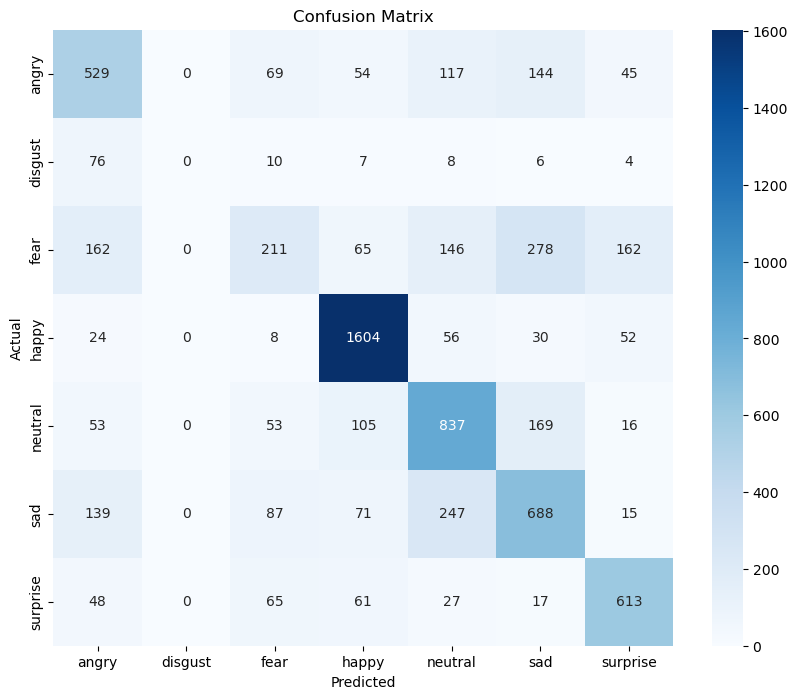

In [24]:
test_acc_clip = evaluate_model(model_clip_classifier, dataloaders['test'], class_names)

**Save the model**

In [25]:
torch.save(model_clip_classifier.state_dict(), './models/clip_fer.pth')

**PLot Learning Curves**

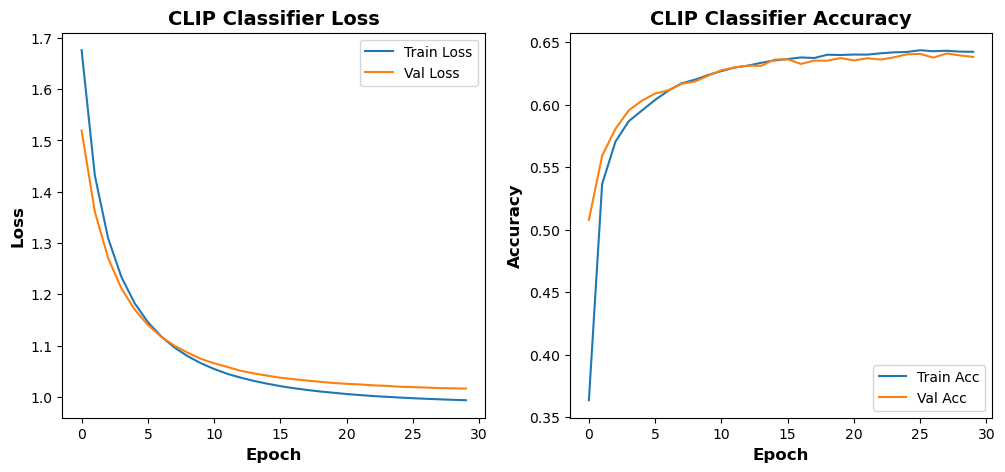

In [26]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_clip['train_loss'], label='Train Loss')
plt.plot(history_clip['val_loss'], label='Val Loss')
plt.title('CLIP Classifier Loss', fontweight='bold', fontsize=14)
plt.xlabel('Epoch', fontweight='bold', fontsize=12)
plt.ylabel('Loss', fontweight='bold', fontsize=12)
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_clip['train_acc'], label='Train Acc')
plt.plot(history_clip['val_acc'], label='Val Acc')
plt.xlabel('Epoch', fontweight='bold', fontsize=12)
plt.ylabel('Accuracy', fontweight='bold', fontsize=12)
plt.legend()
plt.title('CLIP Classifier Accuracy', fontweight='bold', fontsize=14)

plt.show()

---

**Models Comparison**

In [42]:
results = {
    'Model': ['ResNet18', 'clip-vit-base-patch32'],
    'Accuracy': [
        test_acc_resnet18,
        test_acc_clip
    ],
    'Training Time': [
        train_time_resnet18,
        train_time_clip
    ]
}

In [43]:
# Create DataFrame
df = pd.DataFrame(results)
print(df.to_string(index=False))

                Model  Accuracy  Training Time
             ResNet18  0.672200    3929.000000
clip-vit-base-patch32  0.624408    4595.416563


**Bar chart for accuracy comparison**

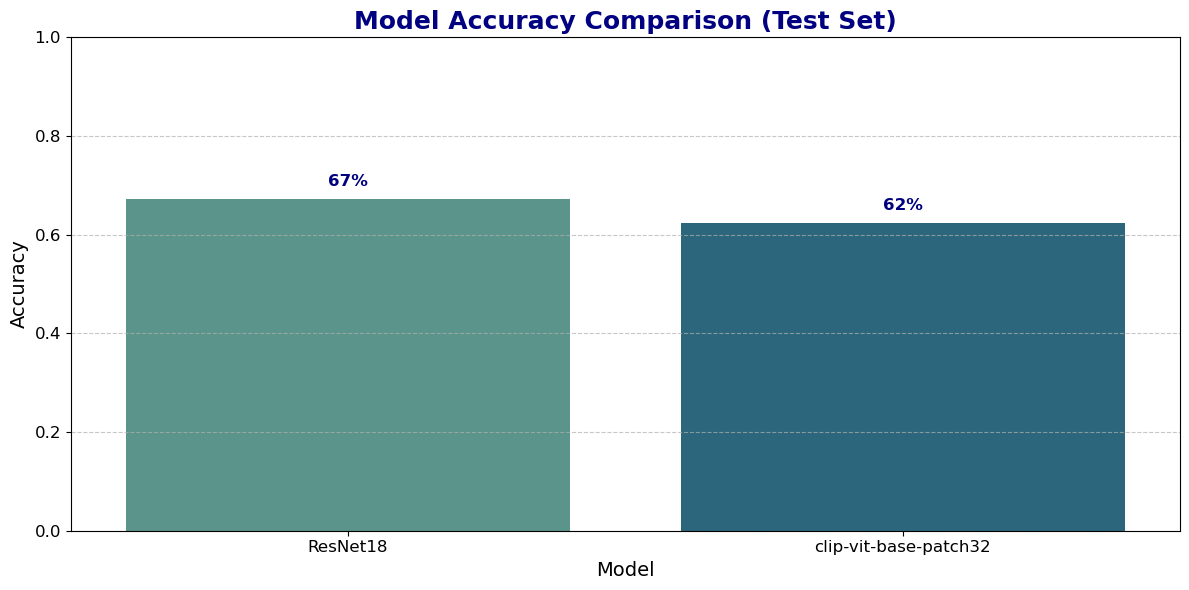

In [55]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='Model', y='Accuracy', palette='crest')

plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding data labels on top of each bar in percentage format
for index, value in enumerate(df['Accuracy']):
    plt.text(index, value + 0.02, f'{value:.0%}',  # Display as percentage
             ha='center', va='bottom', fontsize=12, fontweight='bold', color="navy")

plt.title('Model Accuracy Comparison (Test Set)', fontsize=18, fontweight='bold', color='navy')
plt.xlabel('Model', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0.0, 1.0)  # Adjust for accuracy range
plt.tight_layout()
plt.show()


**Bar Plot for Training Time**

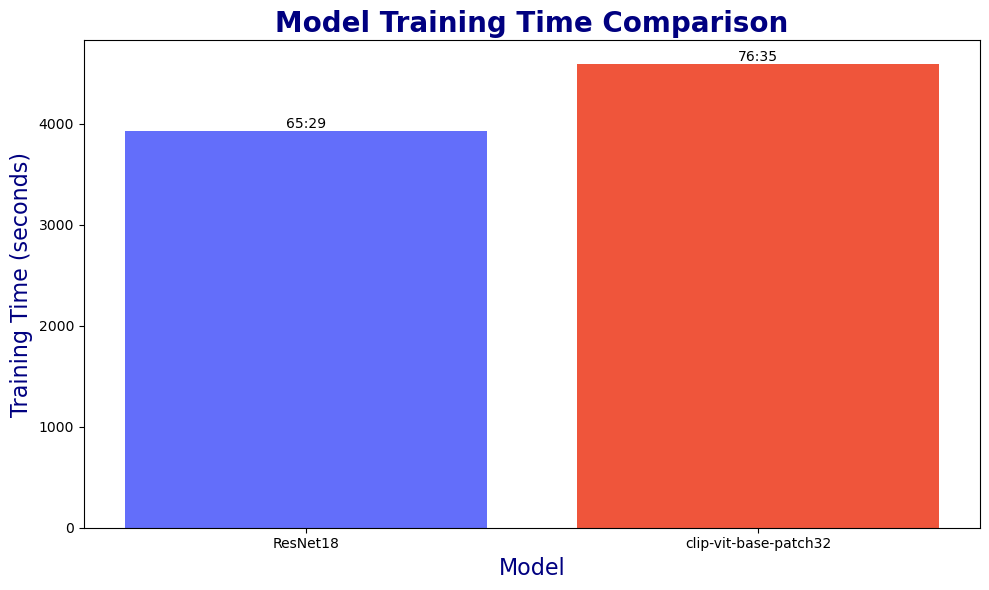

In [49]:
import plotly.express as px

# Convert seconds to minutes:seconds format for display
df['Training Time (m:s)'] = df['Training Time'].apply(lambda x: f"{int(x // 60)}:{int(x % 60):02d}")

plt.figure(figsize=(10, 6))
bars = plt.bar(df['Model'], df['Training Time'], color=px.colors.qualitative.Plotly)

# Add labels on top of the bars using the minutes:seconds format
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, df['Training Time (m:s)'][bars.index(bar)], ha='center', va='bottom')

plt.title('Model Training Time Comparison', fontsize=20, fontweight='bold', color='navy')
plt.xlabel('Model', fontsize=16, color='navy')
plt.ylabel('Training Time (seconds)', fontsize=16, color='navy')
plt.tight_layout()
plt.show()

---